In [1]:
!git clone https://github.com/adasegroup/FDS2020_seminars
!pip -q install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17
%cd FDS2020_seminars/Week\ 6/Day\ 3/

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

## Image loading and transformations

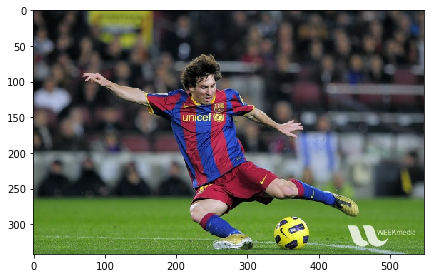

In [3]:
image = cv.imread('assets/messi5.jpg')
rows, cols, ch = image.shape

def show_image(image, figsize=(7,7)):
    plt.figure(figsize=figsize)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    return None

show_image(image)

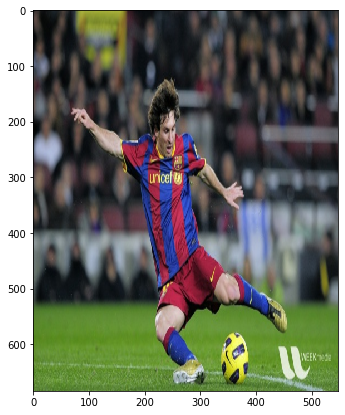

In [4]:
# scaling
dst = cv.resize(image, None, fx=1, fy=2)
show_image(dst)

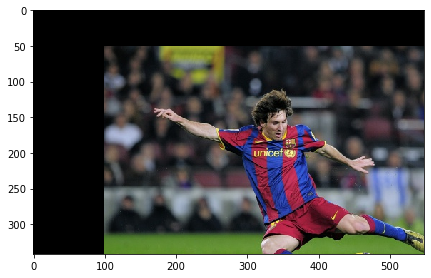

In [5]:
# translation
M = np.float32([[1,0,100], [0,1,50]])
dst = cv.warpAffine(image, M, (cols,rows))
show_image(dst)

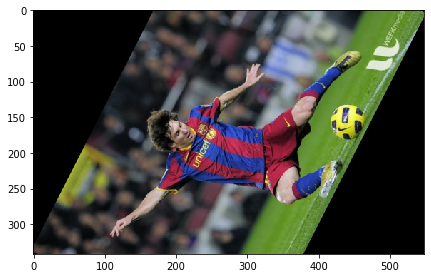

In [6]:
# rotation
# cols-1 and rows-1 are the coordinate limits.
M = cv.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 63, 1)
dst = cv.warpAffine(image, M, (cols,rows))
show_image(dst)

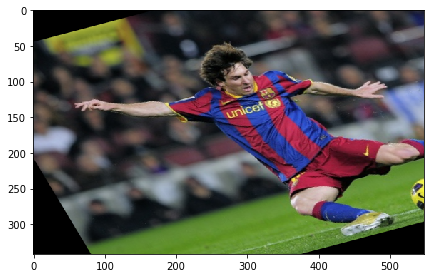

In [7]:
# affine transformation
pts1 = np.float32([[50,50], [200,50], [50,200]])
pts2 = np.float32([[10,100], [200,50], [100,250]])
M = cv.getAffineTransform(pts1, pts2)
dst = cv.warpAffine(image, M, (cols,rows))
show_image(dst)

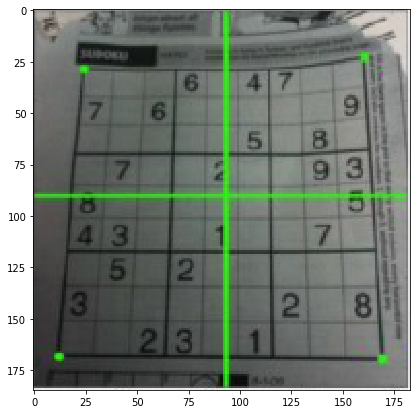

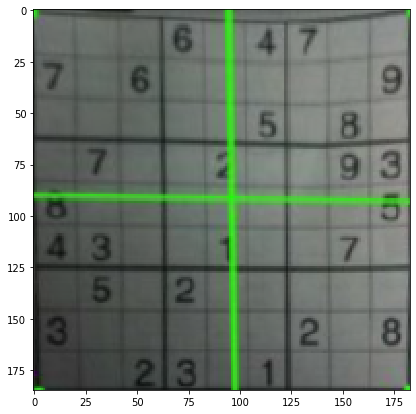

In [8]:
# perspective transformation
image = cv.imread('assets/sudoku.png')
show_image(image)

rows, cols, ch = image.shape
pts1 = np.float32([[25,28], [160,23], [10,168], [170,170]])
pts2 = np.float32([[0,0], [183,0], [0,185], [183,185]])

M = cv.getPerspectiveTransform(pts1, pts2)
dst = cv.warpPerspective(image, M, (183,185))
show_image(dst)

## Camera calibration
### Checkerboard pattern

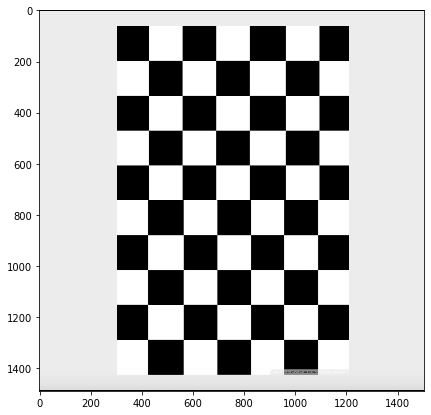

In [9]:
pattern = cv.imread('assets/checker_pattern.png')
show_image(pattern)

In [10]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
objp = np.zeros((1,6*9,3), np.float32)
objp[0,:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

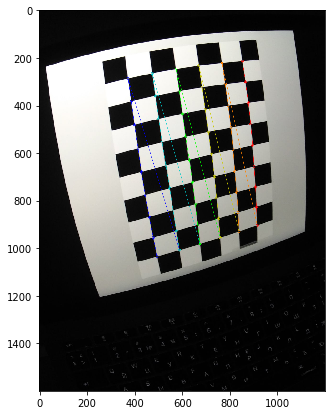

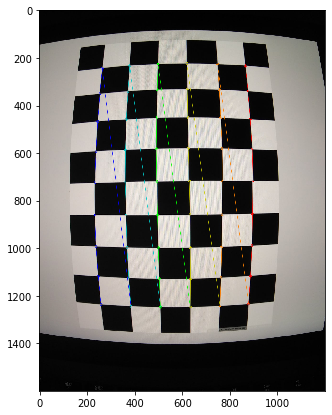

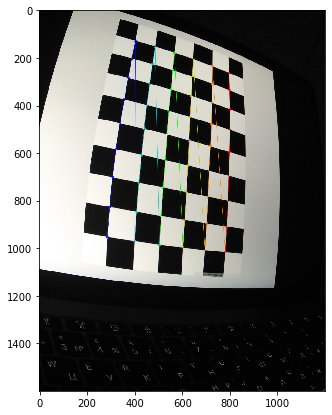

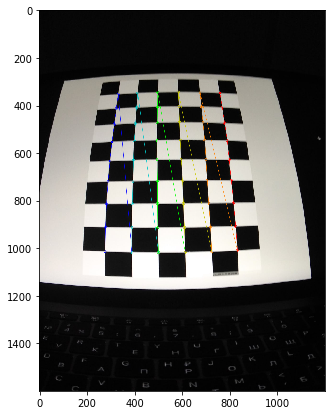

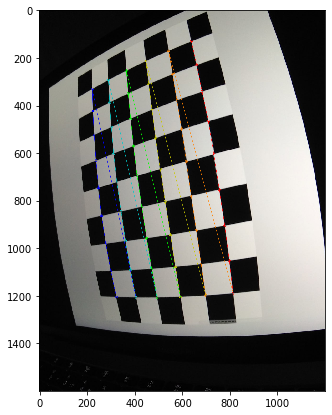

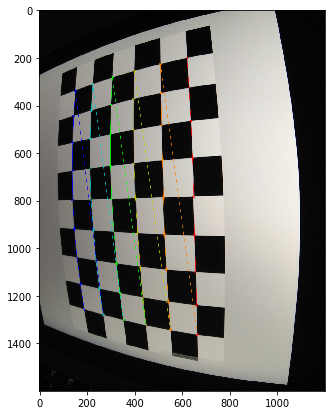

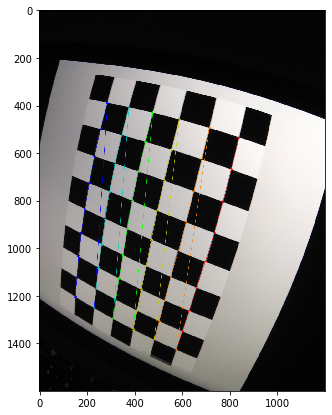

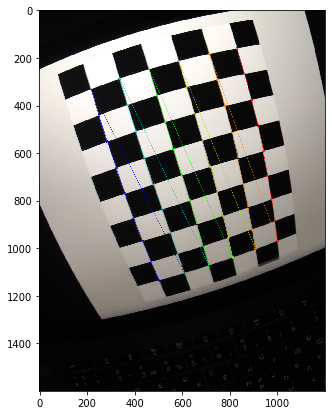

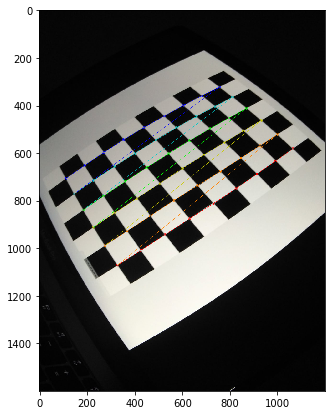

In [11]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = np.sort(glob.glob('checkerboard/checker*.jpg'))

for fname in images[:-1]:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (9,6), corners2, ret)
        show_image(img)

In [12]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv.imread(images[-1])
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [13]:
print('Matrix:\n', mtx)
print('Distortion coefficients:\n', dist)
print('Refined matrix:\n', newcameramtx)

Matrix:
 [[1.84902164e+03 0.00000000e+00 5.95359140e+02]
 [0.00000000e+00 1.89036488e+03 8.19086990e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[-1.23724949e+00  2.68566921e+00 -9.03393522e-03 -1.59316662e-03
  -3.42025058e+00]]
Refined matrix:
 [[1.10349194e+03 0.00000000e+00 5.12542487e+02]
 [0.00000000e+00 7.56543213e+02 8.15783612e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


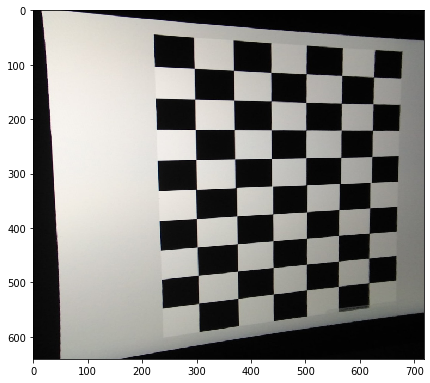

In [14]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
show_image(dst)

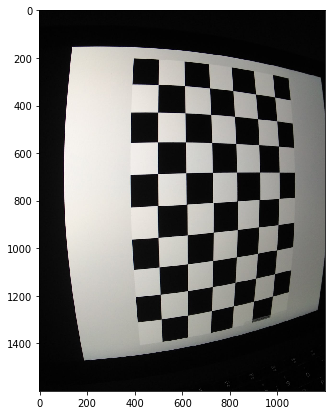

In [15]:
show_image(img)

In [16]:
mean_error = 0
for i in np.arange(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.2777637745650443


### Circular grid pattern

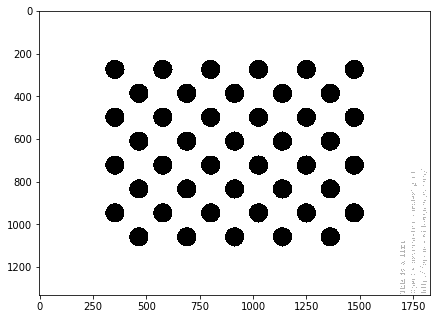

In [17]:
pattern = cv.imread('assets/circles_pattern.png')
show_image(pattern)

In [18]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Setup SimpleBlobDetector parameters.
blobParams = cv.SimpleBlobDetector_Params()

# Create a detector with the parameters
blobDetector = cv.SimpleBlobDetector_create(blobParams)

In [19]:
# Original blob coordinates, supposing all blobs are of z-coordinates 0
objp = np.zeros((1, 44, 3), np.float32)

for i in range(objp[0].shape[0]):
    if (i // 4) % 2 == 0:
        objp[0,i] = (i // 4, i % 4 * 2, 0)
    else: objp[0,i] = (i // 4, i % 4 * 2 + 1, 0)

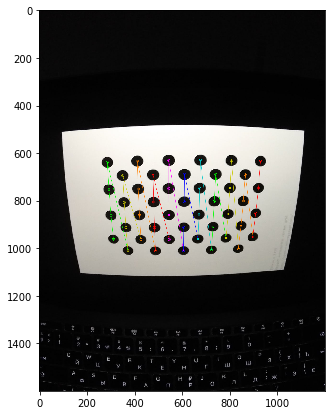

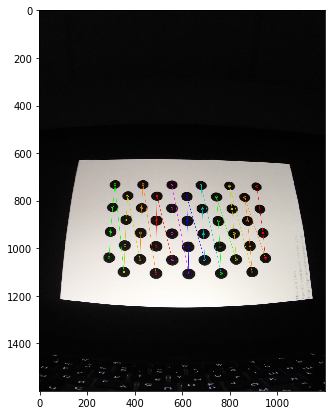

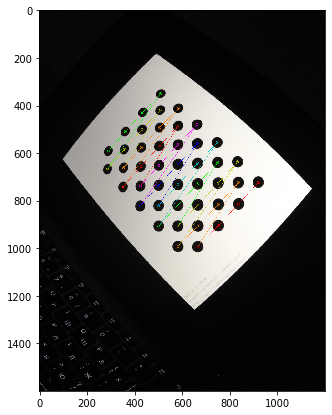

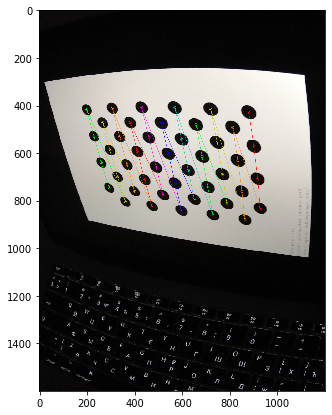

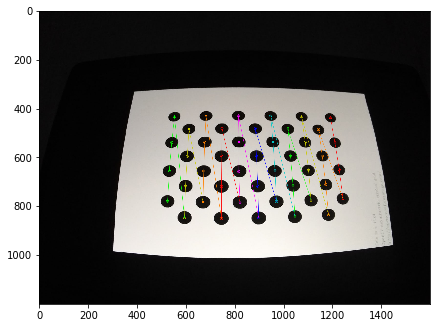

In [20]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = np.sort(glob.glob('circular_grid/circle*.jpg'))

for fname in images[:-1]:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    keypoints = blobDetector.detect(gray) # Detect blobs.

    # Draw detected blobs as red circles. This helps cv.findCirclesGrid() . 
    im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0,255,0), 
                                         cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    im_with_keypoints_gray = cv.cvtColor(im_with_keypoints, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findCirclesGrid(im_with_keypoints, (4,11), None, 
                                      flags = cv.CALIB_CB_ASYMMETRIC_GRID)   # Find the circle grid
    
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(im_with_keypoints_gray, corners, (11,11), (-1,-1), 
                                   criteria)    # Refines the circle locations.
        imgpoints.append(corners2)

        # Draw and display the corners.
        im_with_keypoints = cv.drawChessboardCorners(img, (4,11), corners2, ret)
        show_image(im_with_keypoints)

In [21]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv.imread(images[-1])
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [22]:
print('Matrix:\n', mtx)
print('Distortion coefficients:\n', dist)
print('Refined matrix:\n', newcameramtx)

Matrix:
 [[1.89764161e+03 0.00000000e+00 8.68193660e+02]
 [0.00000000e+00 1.89280698e+03 8.70325057e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[-0.39167156 -4.27005743 -0.02674507 -0.05721583 11.94873709]]
Refined matrix:
 [[1.54772180e+03 0.00000000e+00 8.13575778e+02]
 [0.00000000e+00 1.52606738e+03 8.22976250e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


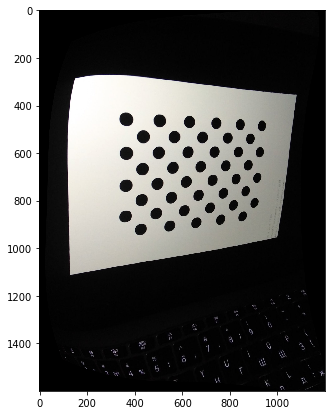

In [23]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

show_image(dst)

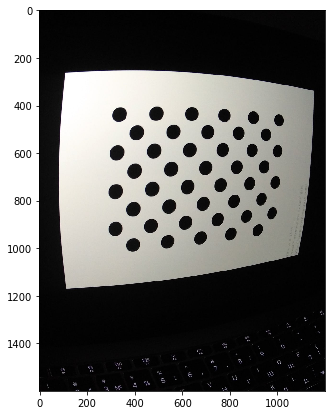

In [24]:
show_image(img)

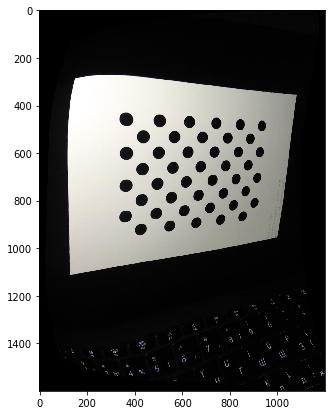

In [25]:
# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

show_image(dst)

In [26]:
mean_error = 0
for i in np.arange(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.2648354143510411


### Fisheye lense model

In [27]:
calibration_flags = cv.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv.fisheye.CALIB_CHECK_COND + cv.fisheye.CALIB_FIX_SKEW

In [28]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
ret, mtx, dist, rvecs, tvecs = cv.fisheye.calibrate(objpoints, imgpoints, 
                                                    gray.shape[::-1], K, D, 
                                                    rvecs, tvecs, calibration_flags, criteria)

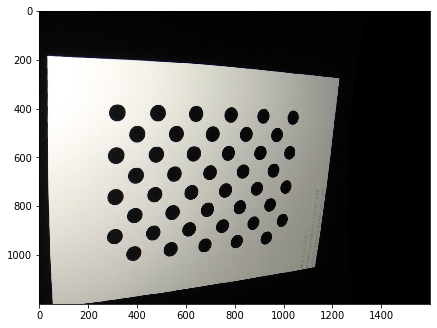

In [29]:
DIM=img.shape[:2]

h,w = img.shape[:2]
map1, map2 = cv.fisheye.initUndistortRectifyMap(mtx, dist, np.eye(3), mtx, DIM, cv.CV_16SC2)
undistorted_img = cv.remap(img, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)
show_image(undistorted_img)

## Epipolar geometry

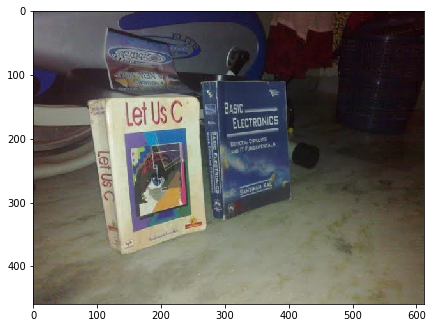

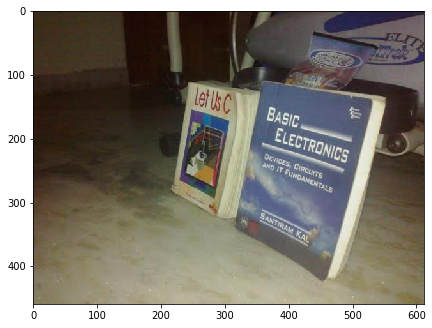

In [30]:
img1 = cv.imread('assets/left.jpg')  #queryimage # left image
img2 = cv.imread('assets/right.jpg') #trainimage # right image

show_image(img1)
show_image(img2)

In [31]:
sift = cv.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [32]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.85 * n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [33]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [34]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, ch = img1.shape
    
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2] / r[1]])
        x1,y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

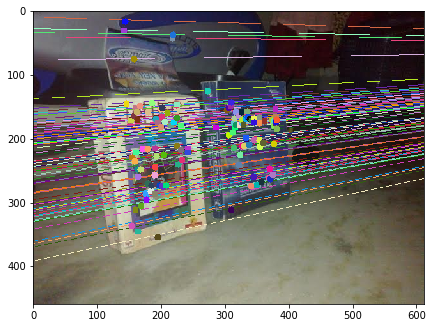

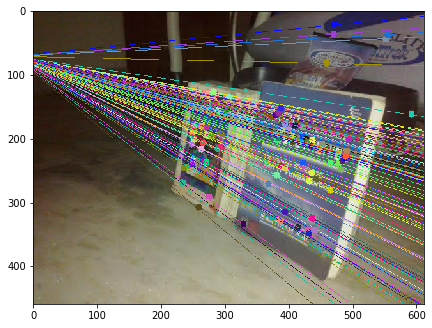

In [35]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)
show_image(img5)
show_image(img3)